# 📚 Import Libraries

In [1]:
!cp -r /kaggle/input/timmmaster . 

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [2]:
!pip install -qU ./timmmaster

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [3]:
!pip install -q /kaggle/input/rsna-bcd-whl-ds/python_gdcm-3.0.20-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
!pip install -q /kaggle/input/rsna-bcd-whl-ds/pylibjpeg-1.4.0-py3-none-any.whl
!pip install -q /kaggle/input/rsna-bcd-whl-ds/dicomsdl-0.109.1-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [4]:
import pandas as pd
import numpy as np
from glob import glob
from collections import defaultdict
from tqdm import tqdm
import time
import os 
import copy
import gc

# visualization
import cv2
import matplotlib.pyplot as plt

# Sklearn
from sklearn.model_selection import StratifiedKFold, KFold, StratifiedGroupKFold,GroupKFold 
from multiprocessing import cpu_count
# PyTorch 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp
from torchvision.ops import sigmoid_focal_loss

import timm

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Metrics 
from sklearn.metrics import roc_auc_score

# For colored terminal text
from colorama import Fore, Back, Style
c_  = Fore.GREEN
sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings('ignore')

# ⚙️ Configuration

In [5]:
class CFG:
    seed          = 2307
    debug         = False # set debug=False for Full Training
    comment       = ""
    folds         = 5
    backbone      = "convnextv2_base"
    train_bs      = 1
    valid_bs      = 2
    epochs        = 25
    lr            = 1.2e-5
    scheduler     = 'CosineAnnealingLR'
    min_lr        = 1e-6
    T_max         = int(30000/train_bs*epochs)+50
    T_0           = 25
    warmup_epochs = 1
    wd            = 1e-6
    img_size      = (960,1536)
    n_accumulate  = 1#max(1, 32//train_bs)
    device        = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    resize_dim = 1024
    aspect_ratio = True
    thr          = 0.65
# Dimensions of processed images
TARGET_HEIGHT = 1536
TARGET_WIDTH = 960
N_CHANNELS = 1
TARGET_HEIGHT_WIDTH_RATIO = TARGET_HEIGHT / TARGET_WIDTH

In [6]:
def set_seed(seed = 42):
    np.random.seed(seed)
    #random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    print('> SEEDING DONE')
    
set_seed(CFG.seed)

> SEEDING DONE


In [7]:
Data_dir = "/kaggle/input/rsna-breast-cancer-detection/test_images/*"

# ❗ Data

In [8]:
df = pd.read_csv("/kaggle/input/rsna-breast-cancer-detection/test.csv")
df

,site_id,patient_id,image_id,laterality,view,age,implant,machine_id,prediction_id
0,2,10008,736471439,L,MLO,81,0,21,10008_L
1,2,10008,1591370361,L,CC,81,0,21,10008_L
2,2,10008,68070693,R,MLO,81,0,21,10008_R
3,2,10008,361203119,R,CC,81,0,21,10008_R


In [9]:
df["dicom_path"] = "/kaggle/input/rsna-breast-cancer-detection/test_images/" + df.patient_id.astype(str) + '/' + df.image_id.astype(str) + '.dcm'
df

,site_id,patient_id,image_id,laterality,view,age,implant,machine_id,prediction_id,dicom_path
0,2,10008,736471439,L,MLO,81,0,21,10008_L,/kaggle/input/rsna-breast-cancer-detection/tes...
1,2,10008,1591370361,L,CC,81,0,21,10008_L,/kaggle/input/rsna-breast-cancer-detection/tes...
2,2,10008,68070693,R,MLO,81,0,21,10008_R,/kaggle/input/rsna-breast-cancer-detection/tes...
3,2,10008,361203119,R,CC,81,0,21,10008_R,/kaggle/input/rsna-breast-cancer-detection/tes...


In [10]:
!rm -r /tmp/Dataset/rsna-bcd
os.makedirs('/tmp/dataset/rsna-bcd/test_images', exist_ok = True)

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
rm: cannot remove '/tmp/Dataset/rsna-bcd': No such file or directory


In [11]:
import cv2
import dicomsdl
def voi_lut(image, dicom):
    # Load only the variables we need
    center = dicom['WindowCenter']
    width = dicom['WindowWidth']
    bits_stored = dicom['BitsStored']
    voi_lut_function = dicom['VOILUTFunction']

    # For sigmoid it's a list, otherwise a single value
    if isinstance(center, list):
        center = center[0]
    if isinstance(width, list):
        width = width[0]

    # Set y_min, max & range
    y_min = 0
    y_max = float(2**bits_stored - 1)
    y_range = y_max

    # Function with default LINEAR (so for Nan, it will use linear)
    if voi_lut_function == 'SIGMOID':
        image = y_range / (1 + np.exp(-4 * (image - center) / width)) + y_min
    else:
        # Checks width for < 1 (in our case not necessary, always >= 750)
        center -= 0.5
        width -= 1

        below = image <= (center - width / 2)
        above = image > (center + width / 2)
        between = np.logical_and(~below, ~above)

        image[below] = y_min
        image[above] = y_max
        if between.any():
            image[between] = (
                ((image[between] - center) / width + 0.5) * y_range + y_min
            )

    # Normalize to have 0 as background, some images are reversed where 0 is max intensity


    return image

def smooth(l):
    # kernel size is 1% of vector
    kernel_size = int(len(l) * 0.01)
    kernel = np.ones(kernel_size) / kernel_size
    return np.convolve(l, kernel, mode='same')

# X Crop offset based on first column with sum below 5% of maximum column sums*std
def get_x_offset(image, max_col_sum_ratio_threshold=0.05, debug=None):
    # Image Dimensions
    H, W = image.shape
    # Percentual margin added to offset
    margin = int(image.shape[1] * 0.00)
    # Threshold values based on smoothed sum x std to capture varying intensity columns
    vv = smooth(image.sum(axis=0).squeeze()) * smooth(image.std(axis=0).squeeze())
    # Find maximum sum in first 75% of columns
    vv_argmax = vv[:int(image.shape[1] * 0.75)].argmax()
    # Threshold value
    vv_threshold = vv.max() * max_col_sum_ratio_threshold
    
    # Find first column after maximum column below threshold value
    for offset, v in enumerate(vv):
        # Start searching from vv_argmax
        if offset < vv_argmax:
            continue
        
        # Column below threshold value found
        if v < vv_threshold:
            offset = min(W, offset + margin)
            break
            
    if isinstance(debug, np.ndarray):
        debug[1].imshow(image)
        debug[1].set_title('X Offset')
        vv_scale = H / vv.max() * 0.90
        # Values
        debug[1].plot(H - vv * vv_scale , c='red', label='vv')
        # Threshold
        debug[1].hlines(H - vv_threshold * vv_scale, 0, W -1, colors='orange', label='threshold')
        # Max Value
        debug[1].scatter(vv_argmax, H - vv[vv_argmax] * vv_scale, c='blue', s=100, label='Max', zorder=np.PINF)
        # First Column Below Threshold
        debug[1].scatter(offset, H - vv[offset] * vv_scale, c='purple', s=100, label='Offset', zorder=np.PINF)
        debug[1].set_ylim(H, 0)
        debug[1].legend()
        debug[1].axis('off')
        
    return offset

# Y Crop offset based on first bottom and top rows with sum below 10% of maximum row sum*std
def get_y_offsets(image, max_row_sum_ratio_threshold=0.10, debug=None):
    # Image Dimensions
    H, W = image.shape
    # Margin to add to offsets
    margin = 0
    # Threshold values based on smoothed sum x std to capture varying intensity columns
    vv = smooth(image.sum(axis=1).squeeze()) * smooth(image.std(axis=1).squeeze())
    # Find maximum sum * std row in inter quartile rows
    vv_argmax = int(image.shape[0] * 0.25) + vv[int(image.shape[0] * 0.25):int(image.shape[0] * 0.75)].argmax()
    # Threshold value
    vv_threshold = vv.max() * max_row_sum_ratio_threshold
    # Default crop offsets
    offset_bottom = 0
    offset_top = H

    # Bottom offset, search from argmax to bottom
    for offset in reversed(range(0, vv_argmax)):
        v = vv[offset]
        if v < vv_threshold:
            offset_bottom = offset
            break
    
    if isinstance(debug, np.ndarray):
        debug[2].imshow(image)
        debug[2].set_title('Y Bottom Offset')
        vv_scale = W / vv.max() * 0.90
        # Values
        debug[2].plot(vv * vv_scale, np.arange(H), c='red', label='vv')
        # Threshold
        debug[2].vlines(vv_threshold * vv_scale, 0, H -1, colors='orange', label='threshold')
        # Max Value
        debug[2].scatter(vv[vv_argmax] * vv_scale, vv_argmax, c='blue', s=100, label='Max', zorder=np.PINF)
        # First Column Below Threshold
        debug[2].scatter(vv[offset_bottom] * vv_scale, offset_bottom, c='purple', s=100, label='Offset', zorder=np.PINF)
        debug[2].set_ylim(H, 0)
        debug[2].legend()
        debug[2].axis('off')
            
    # Top offset, search from argmax to top
    for offset in range(vv_argmax, H):
        v = vv[offset]
        if v < vv_threshold:
            offset_top = offset
            break
            
    if isinstance(debug, np.ndarray):
        debug[3].imshow(image)
        debug[3].set_title('Y Top Offset')
        vv_scale = W / vv.max() * 0.90
        # Values
        debug[3].plot(vv * vv_scale, np.arange(H) , c='red', label='vv')
        # Threshold
        debug[3].vlines(vv_threshold * vv_scale, 0, H -1, colors='orange', label='threshold')
        # Max Value
        debug[3].scatter(vv[vv_argmax] * vv_scale, vv_argmax, c='blue', s=100, label='Max', zorder=np.PINF)
        # First Column Below Threshold
        debug[3].scatter(vv[offset_top] * vv_scale, offset_top, c='purple', s=100, label='Offset', zorder=np.PINF)
        debug[2].set_ylim(H, 0)
        debug[3].legend()
        debug[3].axis('off')
            
    return max(0, offset_bottom - margin), min(image.shape[0], offset_top + margin)

# Crop image and pad offsets to target image height/width ratio to preserve information
def crop(image, size=None, debug=False):
    # Image dimensions
    H, W = image.shape
    # Compute x/bottom/top offsets
    x_offset = get_x_offset(image, debug=debug)
    offset_bottom, offset_top = get_y_offsets(image[:,:x_offset], debug=debug)
    # Crop Height and Width
    h_crop = offset_top - offset_bottom
    w_crop = x_offset
    
    # Pad crop offsets to target aspect ratio
    if size is not None:
        # Height too large, pad x offset
        if (h_crop / w_crop) > TARGET_HEIGHT_WIDTH_RATIO:
            x_offset += int(h_crop / TARGET_HEIGHT_WIDTH_RATIO - w_crop)
        else:
            # Height too small, pad bottom/top offsets
            offset_bottom -= int(0.50 * (w_crop * TARGET_HEIGHT_WIDTH_RATIO - h_crop))
            offset_bottom_correction = max(0, -offset_bottom)
            offset_bottom += offset_bottom_correction

            offset_top += int(0.50 * (w_crop * TARGET_HEIGHT_WIDTH_RATIO - h_crop))
            offset_top += offset_bottom_correction
        
    # Crop Image
    image = image[offset_bottom:offset_top:,:x_offset]
        
    return image

def process(file_path, size=None, dicom_process=True, ret_target=False, crop_image=False,  debug=False):
    # Read Dicom File
    dicom = dicomsdl.open(file_path)
    image = dicom.pixelData()
    
    # Save original image for debug purposes
    if debug:
        fig, axes = plt.subplots(1, 5, figsize=(20,10))
        image0 = np.copy(image)
        axes[0].imshow(image0)
        axes[0].set_title('Original Image')
        axes[0].axis('off')
    else:
        axes = False
        
    try:
        image = voi_lut(image, dicom)
    except:
        pass
    
    if dicom['PhotometricInterpretation'] == 'MONOCHROME1':
        image = np.max(image) - image
    # Normalize [0,1] range
    image = (image - image.min()) / (image.max() - image.min())

    # Convert to uint8 image in range [0, 255]
    image = (image * 255).astype(np.uint8)
    
    # Normalize to left/right orientation by flipping right/left oriented images
    h0, w0 = image.shape
    if image[:,int(-w0 * 0.10):].sum() > image[:,:int(w0 * 0.10)].sum():
        image = np.flip(image, axis=1)
    
    if crop_image:
        image = crop(image, size=size, debug=axes)
    
    # Resize
    if size is not None:
        # Pad black pixels to get correct image ratios
        h, w = image.shape
        if (h / w) > TARGET_HEIGHT_WIDTH_RATIO:
            pad = int(h / TARGET_HEIGHT_WIDTH_RATIO - w)
            image = np.pad(image, [[0,0], [0, pad]])
            h, w = image.shape
        else:
            pad = int(0.50 * (w * TARGET_HEIGHT_WIDTH_RATIO - h))
            image = np.pad(image, [[pad, pad], [0,0]])
            h, w = image.shape
        # Resize
        image = cv2.resize(image, size, interpolation=cv2.INTER_AREA)
        


        
    if debug:
        axes[4].imshow(image)
        axes[4].set_title('Processed Image')
        axes[4].axis('off')
        plt.show()

    # Return Cancer Target
  
    patient_id = int(file_path.split('/')[-2])
    image_id = int(file_path.split('/')[-1].split('.')[0])

    target = f"{IMG_DIR}/test_images/{patient_id}/{image_id}.png"
    os.makedirs(f"{IMG_DIR}/test_images/{patient_id}/", exist_ok=True)
    cv2.imwrite(target, image)

In [12]:
%%time
from joblib import Parallel, delayed
IMG_DIR = '/tmp/dataset/rsna-bcd'
file_paths = df.dicom_path.tolist()
imgsize = Parallel( n_jobs=cpu_count(),
    backend='multiprocessing',
    prefer='threads')(delayed(process)(file_path,crop_image=True,size=(TARGET_WIDTH, TARGET_HEIGHT))\
                                             for file_path in tqdm(file_paths, leave=True, position=0))

100%|██████████| 4/4 [00:01<00:00,  3.14it/s]


CPU times: user 184 ms, sys: 51.3 ms, total: 236 ms
Wall time: 2.54 s


In [13]:
!ls /tmp/dataset/rsna-bcd/test_images/10008

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
1591370361.png	361203119.png  68070693.png  736471439.png


In [14]:
df["path"] = "/tmp/dataset/rsna-bcd/test_images/" + df.patient_id.astype(str) + '/' + df.image_id.astype(str) + '.png'
df

,site_id,patient_id,image_id,laterality,view,age,implant,machine_id,prediction_id,dicom_path,path
0,2,10008,736471439,L,MLO,81,0,21,10008_L,/kaggle/input/rsna-breast-cancer-detection/tes...,/tmp/dataset/rsna-bcd/test_images/10008/736471...
1,2,10008,1591370361,L,CC,81,0,21,10008_L,/kaggle/input/rsna-breast-cancer-detection/tes...,/tmp/dataset/rsna-bcd/test_images/10008/159137...
2,2,10008,68070693,R,MLO,81,0,21,10008_R,/kaggle/input/rsna-breast-cancer-detection/tes...,/tmp/dataset/rsna-bcd/test_images/10008/680706...
3,2,10008,361203119,R,CC,81,0,21,10008_R,/kaggle/input/rsna-breast-cancer-detection/tes...,/tmp/dataset/rsna-bcd/test_images/10008/361203...


# 🔨 Utility

In [15]:
def load_img(path):

    img = cv2.imread(path)
    img = cv2.resize(img ,CFG.img_size)

    #img = img.astype('uint8') #* 255 # original is uint16
    #img/= 255.0
    return img

def show_img(img):
    plt.imshow(img)
    plt.axis('off')

def display_batch(batch, size=2):
    if isinstance(batch, list):
        imgs, tars = batch
    else:
        imgs = batch
        tars = None
    imgs = np.transpose(imgs, (0, 2, 3, 1))
    tars = tars.numpy().squeeze()
    plt.figure(figsize=(size*8, 10))
    for img_idx in range(size):
        plt.subplot(1, size, img_idx+1)
        if tars is not None:
            plt.title(f'cancer: {tars[img_idx]:0.3f}', fontsize=10)
        plt.imshow(imgs[img_idx,:, :, :])
        plt.xticks([]); plt.yticks([])
    plt.tight_layout()
    plt.show()

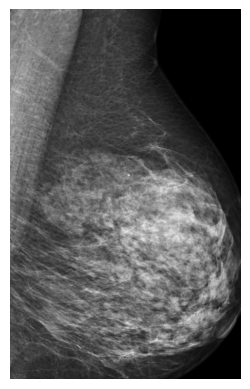

In [16]:
img = load_img(df.path[0:1].item())
show_img(img)

# ❗ DataLoaders

In [17]:
df["data_index"] = df.patient_id.astype(str) + '_' +df.laterality

In [18]:
class RNSADataset(Dataset):
    def __init__(self, df, label=True ,transforms = None):
        self.df = df
        self.transforms = transforms
        self.patient_ids = df.data_index.unique().tolist()
       
        
    def __len__(self):
        return len(self.patient_ids)
  
    def __getitem__(self,index):
        
        pid = self.patient_ids[index]
        data = self.df.query("data_index==@pid and view in ['CC','MLO']")
        bcc   = data.query("view == 'CC'").sample(1).path.values[0]
        mlo  = data.query("view == 'MLO'").sample(1).path.values[0]

        img =  np.hstack( (load_img(bcc) , load_img(mlo) ) )

        if self.transforms:
            result = self.transforms(image=img)
            img = result["image"]
            
        img = np.transpose(img, (2, 0, 1))
    
        return torch.tensor(img),  pid

In [19]:
data_transforms = {
    "train": A.Compose([A.Sharpen(),
                       A.Flip(),
                       A.ShiftScaleRotate(shift_limit = 0.2,scale_limit = 0.5,rotate_limit = 35),
                        A.Cutout(num_holes = 10, max_h_size = 16,max_w_size = 16),
                        A.ColorJitter(brightness=0.15, contrast=[0.8, 1.2], saturation=[0.7, 1.3], hue=0.05),
                        A.Normalize()
                       ], p=1.0),
    "valid": A.Compose([A.Normalize()], p=1.0)
}

In [20]:
def prepare_loaders(df, debug=False):

    

    valid_dataset = RNSADataset(df, transforms=data_transforms['valid'])

    valid_loader = DataLoader(valid_dataset, batch_size=CFG.valid_bs if not debug else 3, 
                              num_workers=4, shuffle=False, pin_memory=True)
    
    return valid_loader

In [21]:
valid_loader = prepare_loaders(df=df, debug=False)
batch = next(iter(valid_loader))
img ,label = batch
print(img.size(),label)

torch.Size([2, 3, 1536, 1920]) ['10008_L', '10008_R']


In [22]:
#display_batch(batch, label.shape[0]);

In [23]:
import torch.nn.functional as F
class GeneralizedMeanPooling(nn.Module):
    """Applies a 2D power-average adaptive pooling over an input signal composed of several input planes.
    The function computed is: :math:`f(X) = pow(sum(pow(X, p)), 1/p)`
        - At p = infinity, one gets Max Pooling
        - At p = 1, one gets Average Pooling
    The output is of size H x W, for any input size.
    The number of output features is equal to the number of input planes.
    Args:
        output_size: the target output size of the image of the form H x W.
                     Can be a tuple (H, W) or a single H for a square image H x H
                     H and W can be either a ``int``, or ``None`` which means the size will
                     be the same as that of the input.
    """

    def __init__(self, norm, output_size=1, eps=1e-6):
        super(GeneralizedMeanPooling, self).__init__()
        assert norm > 0
        self.p = float(norm)
        self.output_size = output_size
        self.eps = eps

    def forward(self, x):
        x = x.clamp(min=self.eps).pow(self.p)
        return F.adaptive_avg_pool2d(x, self.output_size).pow(1. / self.p)

    def __repr__(self):
        return self.__class__.__name__ + '(' \
            + str(self.p) + ', ' \
            + 'output_size=' + str(self.output_size) + ')'

In [24]:
class RNSAModel(nn.Module):

    def __init__(self, model_name=CFG.backbone, num_classes=2, pretrained=True):
        super().__init__()
        self.base = timm.create_model(model_name, pretrained=pretrained, num_classes=1)
        self.out  = self.base.get_classifier().in_features
        #self.base.reset_classifier(0)
        self.pool = GeneralizedMeanPooling(3)
        
        self.althead = nn.Sequential(
                       nn.Linear(self.out,512),
                       nn.SELU(),
                        nn.Linear(512,128),
                       nn.SELU(),
                        nn.Linear(128,64),
                       nn.SELU(),
                       nn.Linear(64,1)
                    )


    def forward(self, x):
        x =  self.base.forward_features(x) 
        x = self.pool(x)
        x = x.view(-1,self.out)
        x = self.althead(x)
        return x 

In [25]:
def get_model(path):
    model = RNSAModel(CFG.backbone ,pretrained = False).to(CFG.device)
    try:
        state_dict = torch.load(path,map_location=torch.device(CFG.device))["model"]
    except:
        state_dict = torch.load(path,map_location=torch.device(CFG.device))
    for key in list(state_dict.keys()):
        state_dict[key.replace('module.', '')] = state_dict.pop(key)
    model.load_state_dict(state_dict)
    model.eval()
    return model

In [26]:
#list(m.named_modules())[-8]

# 🔧 Loss Function

# 🚄 Training Function

In [27]:
@torch.no_grad()
def run_test(models, dataloader):
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Valid ')
    n_models = range(len(models))
    preds = [[] for i in n_models] ; ids = []
    for step, (images,labels) in pbar:         
        images = images.to(CFG.device, dtype=torch.float)
        
        pred = [nn.Sigmoid()(model(images)).cpu().detach().numpy().reshape(-1) for model in models]
        ids.extend(labels)
        for i in n_models:
            preds[i].extend(pred[i])
    df_dict = {'prediction_id':ids}
    df_dict.update({f'cancer{i}':preds[i] for i in n_models})
    pred_df = pd.DataFrame(df_dict)
    return pred_df

In [28]:
test_loader = prepare_loaders( df=df, debug = CFG.debug)
l = ["/kaggle/input/rnsabctpu/best_epoch-22-0.bin"]
models     = [get_model(i) for i in l]

In [29]:



preds = run_test(models, test_loader )



Valid : 100%|██████████| 1/1 [00:05<00:00,  5.59s/it]


In [30]:
preds["cancer"] = preds.mean(axis=1)

In [31]:
preds

,prediction_id,cancer0,cancer
0,10008_L,0.070490,0.070490
1,10008_R,0.121813,0.121813


In [32]:
sub_df = preds.groupby('prediction_id')['cancer'].max().reset_index()  # merge duplicate prediction_id
thr = sub_df.cancer.quantile(1-0.0206)
sub_df['cancer'] = (sub_df.cancer>thr).astype('float64') # thresholding
sub_df

,prediction_id,cancer
0,10008_L,0.0
1,10008_R,1.0


In [33]:
sub_df.to_csv('submission.csv',index=False)

In [34]:
pd.read_csv("/kaggle/input/rsna-breast-cancer-detection/sample_submission.csv").dtypes

prediction_id     object
cancer           float64
dtype: object

In [35]:
sub_df.dtypes

prediction_id     object
cancer           float64
dtype: object